In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pim_tmr as pim
import matrices as pim_mats
import fibernet
import torch

In [2]:
import mat73
import os
from scipy.io import loadmat

path = "C:\\Users\\saucourt\\Datasets"
file = "data_base_02_03_90deg.mat"
data = mat73.loadmat(os.path.join(path, file))
# data = loadmat(os.path.join(path, file))

In [3]:
model_path = 'C:/Users/saucourt/Coding/fibernet_analysis/training_analysis/trained_models/model_ds=10k_p=1_na=0.2_ep=40.pth'
model = torch.load(model_path)

In [34]:
def retrieve_bias(model):
    return model.bias.cpu().detach().numpy()

def retrieve_matrix(model, num_mats) -> None:
    return [params.data for i in range(num_mats) for params in model.linear_list[i].parameters()][0].cpu().detach().numpy()
    
matrix = retrieve_matrix(model, 1)
bias = retrieve_bias(model)

print(np.transpose(matrix).shape)
print(bias.shape)

(32, 14884)
(122, 122)


In [44]:
CP = np.reshape(np.array(data['CP']), newshape=(-1, 128, 128))
vec = np.reshape(np.array(data['vecteur_36']) , newshape=(-1, 36))

NN = CP.shape[0]
As = np.zeros(shape=(NN, 32), dtype=complex)
Bs = np.zeros(shape=(NN, 122*122), dtype=float)

amp = fibernet.dataset._utils.make_bellshaped_plane_2d(vec[0].reshape((6,6)))
amp = amp.flatten()

for i in range(NN):
    phi = vec[i]
    phi = amp * np.exp(1j * phi)
    phi = np.delete(vec[i], [0, 5, 30, 35])
    img = CP[i][3:125, 3:125]
    img = img - bias
    img = img.flatten().astype('float')
    As[i,:] = phi
    Bs[i,:] = np.sqrt(img/(np.power(2, 16) - 1))

In [48]:
%load_ext autoreload
%autoreload 2

N = 5000
idx = np.random.permutation(np.arange(NN))
As_crop = As[idx[:N], :]
Bs_crop = Bs[idx[:N], :]

# X_est = pim.pim_tmr(As_crop, Bs_crop, max_iter=10000, tol=20e-9, tol_stag=1e-2, max_stag=10)
X_est = pim.pim_tmr(As_crop, Bs_crop, max_iter=10000, init_matrix=np.transpose(matrix), tol=12e-9, tol_stag=1e-2, max_stag=10)
B_est = np.abs(np.dot(As_crop, X_est))
print(f"MSE Bs: {pim.mse(Bs_crop, B_est):0.3e}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
i=    0  mse_glob=1.825e-09  mse_convs=1.819e-09  mse_acts=1.598e-08  act=    7  convs=14877
i=    1  mse_glob=1.825e-09  mse_convs=1.820e-09  mse_acts=1.724e-08  act=    4  convs=14880
i=    2  mse_glob=1.824e-09  mse_convs=1.821e-09  mse_acts=1.725e-08  act=    3  convs=14881
i=    3  mse_glob=1.824e-09  mse_convs=1.821e-09  mse_acts=1.613e-08  act=    3  convs=14881
i=    4  mse_glob=1.824e-09  mse_convs=1.822e-09  mse_acts=1.791e-08  act=    2  convs=14882
i=    5  mse_glob=1.824e-09  mse_convs=1.822e-09  mse_acts=1.773e-08  act=    2  convs=14882
i=    6  mse_glob=1.824e-09  mse_convs=1.822e-09  mse_acts=1.758e-08  act=    2  convs=14882
i=    7  mse_glob=1.824e-09  mse_convs=1.822e-09  mse_acts=1.744e-08  act=    2  convs=14882
i=    8  mse_glob=1.824e-09  mse_convs=1.822e-09  mse_acts=1.730e-08  act=    2  convs=14882
i=    9  mse_glob=1.824e-09  mse_convs=1.822e-09  mse_acts=1.715e-08  act= 

[(-0.5, 121.5, 121.5, -0.5),
 (-0.5, 121.5, 121.5, -0.5),
 (-0.5, 121.5, 121.5, -0.5),
 (-0.5, 121.5, 121.5, -0.5)]

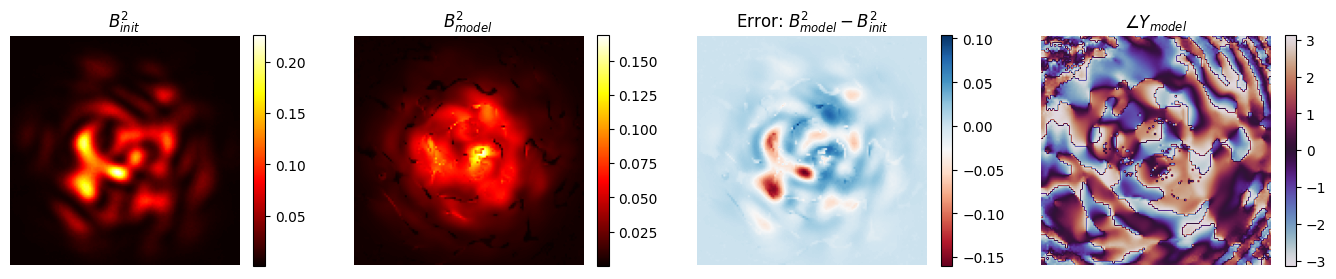

In [53]:
import matplotlib.pyplot as plt

i = np.random.randint(0, N)
A_init = As_crop[i,:]
Y_model = np.dot(X_est.T, A_init).reshape((122,122))
B_model = np.abs(Y_model)
B_init = Bs_crop[i,:].reshape((122,122))

fig, axs = plt.subplots(1,4, figsize=(17,3))
pl0 = axs[0].imshow(np.square(B_init), cmap="hot")
pl1 = axs[1].imshow(np.square(B_model), cmap="hot")
pl2 = axs[2].imshow(np.square(B_model) - np.square(B_init), cmap="RdBu")
pl3 = axs[3].imshow(np.angle(Y_model), cmap="twilight")
plt.colorbar(pl0, ax=axs[0])
plt.colorbar(pl1, ax=axs[1])
plt.colorbar(pl2, ax=axs[2])
plt.colorbar(pl3, ax=axs[3])
axs[0].set_title(r"$B_{init}^2$")
axs[1].set_title(r"$B_{model}^2$")
axs[2].set_title(r"Error: $B_{model}^2 - B_{init}^2$")
axs[3].set_title(r"$\angle Y_{model}$")
[ axs[i].axis('off') for i in range(4) ]